# Hough Transform: Detecting Lines and Circles in Images



## 1. Introduction

### Objective
Learn to detect lines and circles in images using the Hough Transform. We'll start from first principles and build towards practical implementations with Python and OpenCV.

### Why It Matters
- **Shape detection** is a fundamental task in computer vision.
- The Hough Transform helps detect parametric shapes even in noisy or partially occluded images.
- It powers everything from self-driving cars to medical imaging systems.

## 2. Theory from First Principles

### 2.1 The Challenge of Shape Detection
- Raw pixel data is noisy
- Shapes might be incomplete or occluded
- Brute-force pattern matching is computationally expensive

We need a method that is robust to noise, occlusion, and still efficient to compute.


### 2.2 Hough Transform for Lines

#### Step 1: Rethinking Line Equations
Most students learn:
$$ y = mx + b $$

This formulation works fine for most lines, but it breaks for vertical lines where the slope $m$ approaches infinity.

Instead, the Hough Transform uses the **normal form** of a line:
$$ \rho = x\cos\theta + y\sin\theta $$
Where:
- $\rho$ (rho): perpendicular distance from origin to the line
- $\theta$ (theta): angle of the perpendicular line from the origin

**The Key Insight**: Every edge point $(x,y)$ in the image corresponds to a sinusoidal curve in $(\rho, \theta)$ space. Points that lie on the same line in image space produce curves that intersect at a single point in Hough space.


> In the image space (where pixels live at $(x, y)$ coordinates), a line is a bunch of pixels that line up. In Hough space, that same line is just one point: a single $(\rho, \theta)$ pair.

#### Step 2: Building the Accumulator
Transform works by:

1. For each edge pixel at position (x,y):

       We ask: "What combinations of (ρ,θ) would create a line passing through me?"
       For each possible θ value (typically 0° to 179°), we calculate the corresponding ρ
       This creates a sinusoidal curve in (ρ,θ) space
       We increment a counter (a "vote") for each (ρ,θ) combination on this curve




2. Where Voting Happens:

    The "accumulator" is a 2D array where:

       One axis represents different values of θ
       The other axis represents different values of ρ
       Each cell counts how many edge pixels "voted" for that specific (ρ,θ) combination




3. Finding Lines Through Votes:

        If multiple pixels lie on the same line in the image, they will all vote for the same (ρ,θ) values
        This creates a high count (many votes) at that specific location in the accumulator
        By finding "peaks" (cells with many votes) in the accumulator, we identify the most likely lines in the original image

### 2.3 Hough Transform for Circles

Circle equation:
$$ (x - a)^2 + (y - b)^2 = r^2 $$
Where:
- $(a, b)$ is the center coordinates
- $r$ is the radius

To detect circles:
- The accumulator becomes 3D: $(a, b, r)$
- Each edge pixel votes for all possible centers and radii
- Peaks in this 3D space represent likely circles

## Read documentation!

https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

https://docs.opencv.org/3.4/d4/d70/tutorial_hough_circle.html

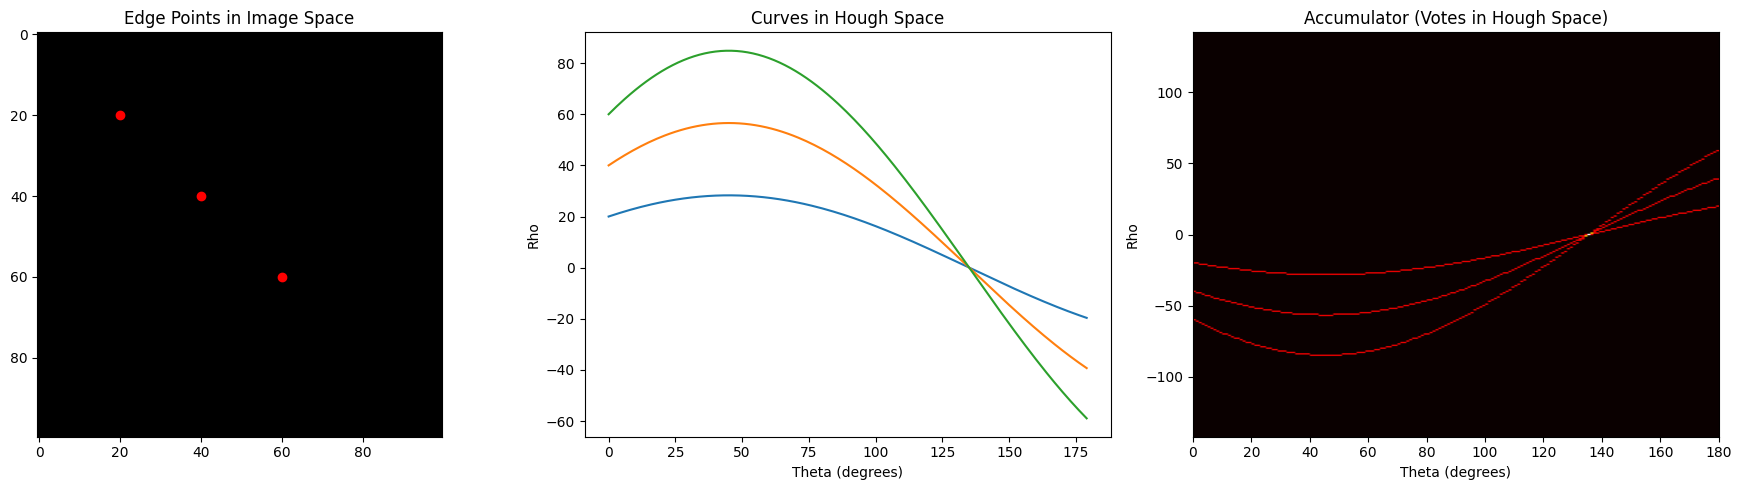

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Create a blank image with 3 edge points forming a straight line
image = np.zeros((100, 100), dtype=np.uint8)
edge_points = [(20, 20), (40, 40), (60, 60)]
for y, x in edge_points:
    image[y, x] = 255

# Hough Transform from scratch for these points
theta_res = 1  # in degrees
rho_res = 1
thetas = np.deg2rad(np.arange(0, 180, theta_res))
height, width = image.shape
diag_len = int(np.ceil(np.sqrt(height**2 + width**2)))
rhos = np.arange(-diag_len, diag_len + 1, rho_res)
accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)

# Voting in Hough space
for y, x in edge_points:
    for theta_idx, theta in enumerate(thetas):
        rho = int(round(x * np.cos(theta) + y * np.sin(theta)))
        rho_idx = rho + diag_len  # shift index to be positive
        accumulator[rho_idx, theta_idx] += 1

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Original image with points
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Edge Points in Image Space")
axs[0].scatter([x for _, x in edge_points], [y for y, _ in edge_points], c='red')

# Plotting the sinusoidal curves each point generates
axs[1].set_title("Curves in Hough Space")
for y, x in edge_points:
    curve_rhos = [x * np.cos(t) + y * np.sin(t) for t in thetas]
    axs[1].plot(np.rad2deg(thetas), curve_rhos)
axs[1].set_xlabel("Theta (degrees)")
axs[1].set_ylabel("Rho")

# Accumulator heatmap
axs[2].imshow(accumulator, extent=[0, 180, -diag_len, diag_len], aspect='auto', cmap='hot')
axs[2].set_title("Accumulator (Votes in Hough Space)")
axs[2].set_xlabel("Theta (degrees)")
axs[2].set_ylabel("Rho")

plt.tight_layout()
plt.show()


## 3. Line Detection with OpenCV

### Step 1: Setup and Preprocessing

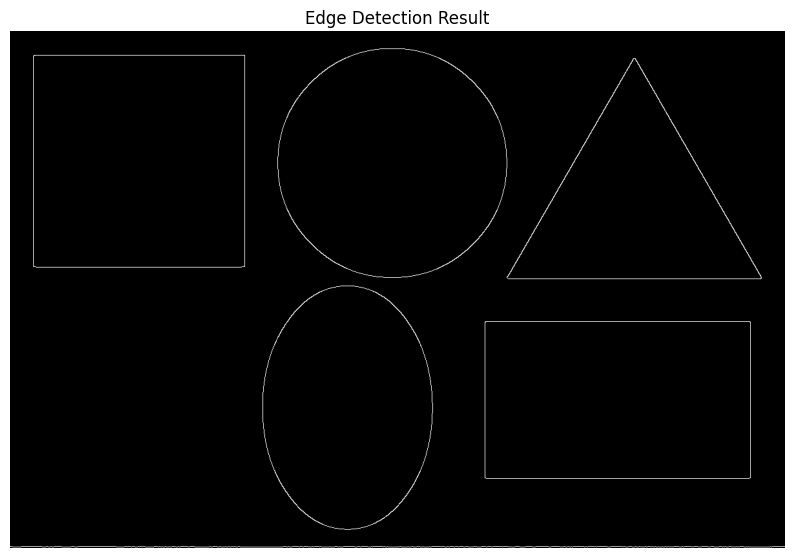

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('shapes.jpg')
original = image.copy()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detector
edges = cv2.Canny(blurred, 50, 150)

# Show edges
plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection Result')
plt.axis('off')
plt.show()

### Step 2: Standard Hough Transform

In [32]:
cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=100)

array([[[ 7.9700000e+02,  1.5707964e+00]],

       [[ 4.4900000e+02,  1.5707964e+00]],

       [[ 6.9200000e+02,  1.5707964e+00]],

       [[ 8.5700000e+02,  5.2359879e-01]],

       [[ 3.8300000e+02,  1.5707964e+00]],

       [[-8.1700000e+02,  2.6179938e+00]],

       [[ 3.7000000e+01,  1.5707964e+00]],

       [[ 3.6300000e+02,  0.0000000e+00]],

       [[ 3.6000000e+01,  0.0000000e+00]],

       [[ 3.6500000e+02,  1.5707964e+00]],

       [[ 7.3500000e+02,  0.0000000e+00]],

       [[ 1.1460000e+03,  0.0000000e+00]],

       [[ 3.6300000e+02,  1.5882496e+00]]], dtype=float32)

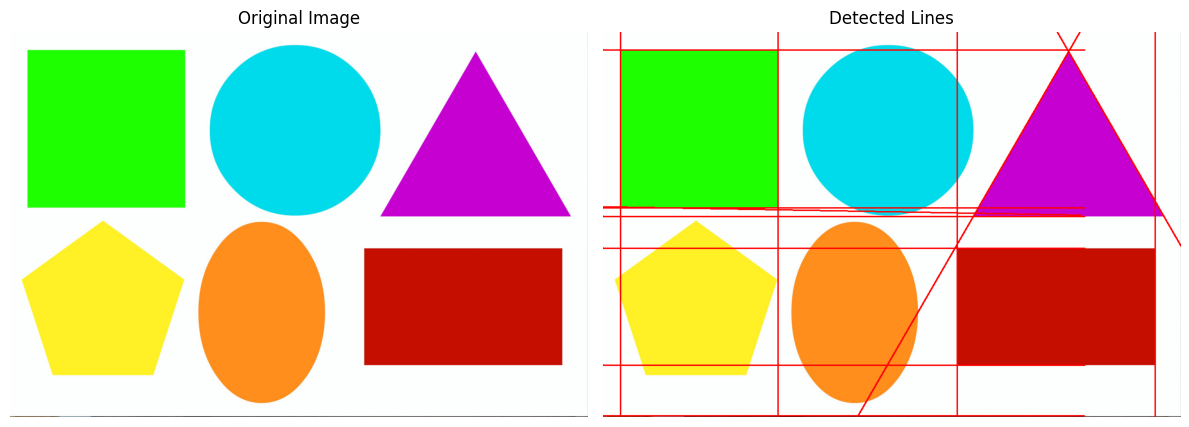

In [31]:
# Apply the Hough Transform
lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=100)

# Draw detected lines on the original image
output = original.copy()
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(output, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Display the result
plt.figure(figsize=(12, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines'), plt.axis('off')
plt.tight_layout()
plt.show()

### Step 3: Probabilistic Hough Transform (Faster!)

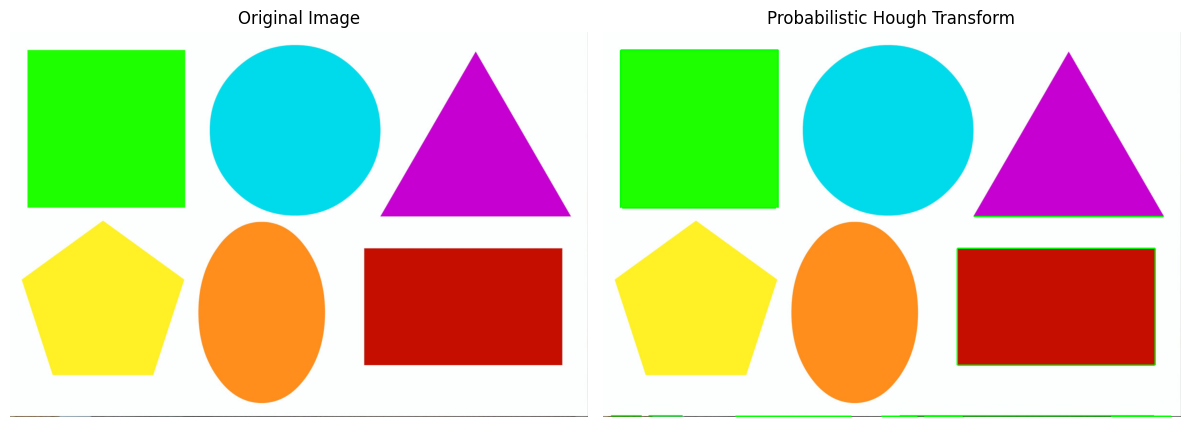

In [30]:
# Apply Probabilistic Hough Transform

lines_p = cv2.HoughLinesP(edges, rho=0.1, theta=np.pi/180, threshold=50, 
                          minLineLength=50, maxLineGap=10)

output = original.copy()
# Draw the lines
if lines_p is not None:
    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        cv2.line(output, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(12, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Probabilistic Hough Transform'), plt.axis('off')
plt.tight_layout()
plt.show()

### Bonus: Let's Visualize Hough Space!

To really understand what's happening, let's actually look at the parameter space:

## 4. Circle Detection with OpenCV

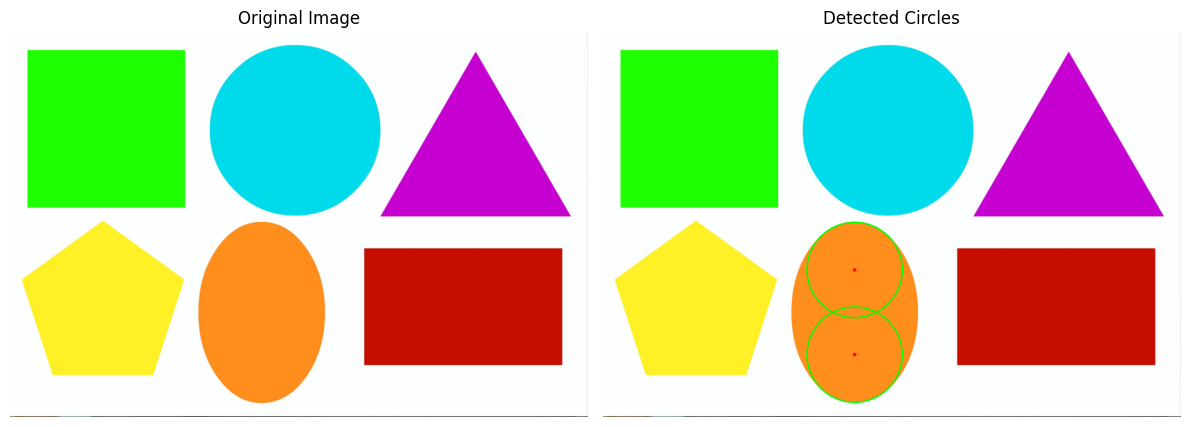

In [15]:
# Load an image with circles
circle_image = cv2.imread('shapes.jpg')
original_circle = circle_image.copy()

# Convert to grayscale
gray_circle = cv2.cvtColor(circle_image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred_circle = cv2.GaussianBlur(gray_circle, (5, 5), 0)

# Apply Hough Transform for circle detection
circles = cv2.HoughCircles(
    blurred_circle,
    cv2.HOUGH_GRADIENT,
    dp=1,           # Resolution ratio of accumulator to image
    minDist=20,     # Minimum distance between detected centers
    param1=50,      # Upper threshold for Canny edge detector
    param2=30,      # Threshold for center detection
    minRadius=10,   # Minimum radius of circles
    maxRadius=100   # Maximum radius of circles
)

# Draw detected circles
output = original_circle.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])
        radius = circle[2]
        
        # Draw the outer circle
        cv2.circle(output, center, radius, (0, 255, 0), 2)
        # Draw the center of the circle
        cv2.circle(output, center, 2, (0, 0, 255), 3)

# Display the results
plt.figure(figsize=(12, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(original_circle, cv2.COLOR_BGR2RGB))
plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles'), plt.axis('off')
plt.tight_layout()
plt.show()

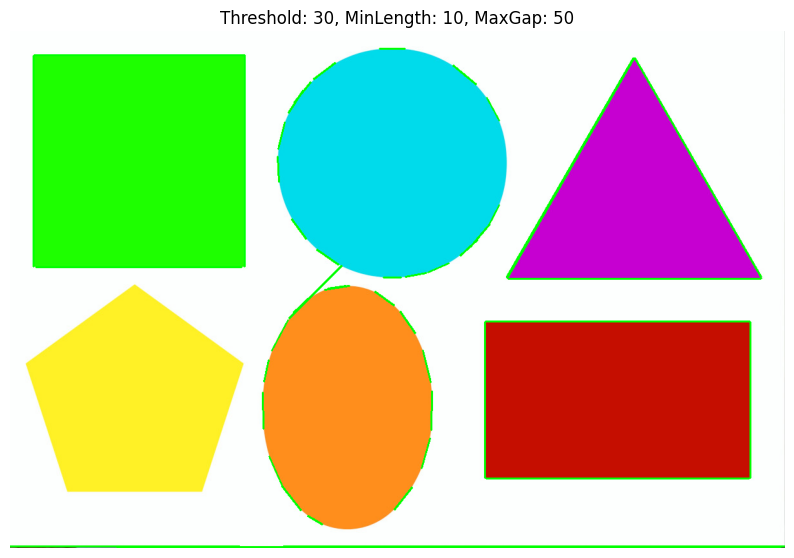

Number of lines detected: 49


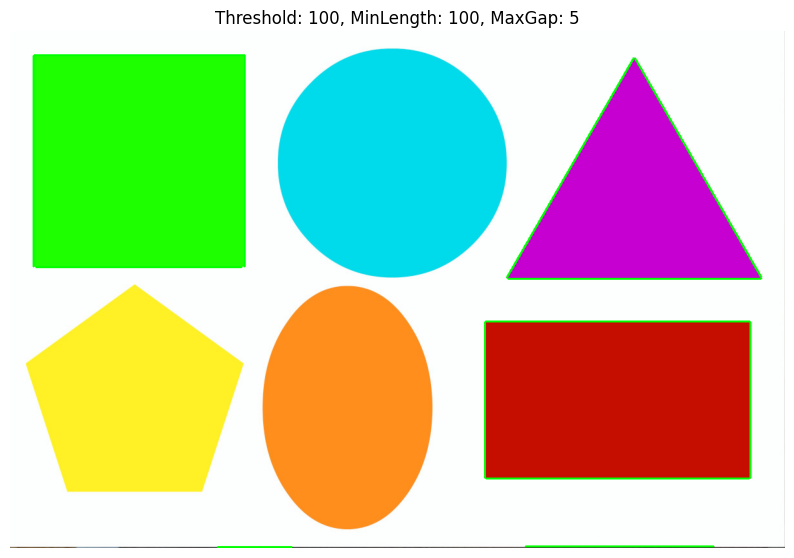

Number of lines detected: 14


In [23]:
# Note: Using `HoughLinesP` directly
def experiment_with_hough_lines(threshold, min_line_length, max_line_gap):
    # Load the original image again
    image = original.copy()
    
    # Apply Probabilistic Hough Transform with custom parameters
    lines_p = cv2.HoughLinesP(edges, 
                              rho=1, 
                              theta=np.pi/180, 
                              threshold=threshold,
                              minLineLength=min_line_length, 
                              maxLineGap=max_line_gap)
    
    # Draw the lines
    if lines_p is not None:
        for line in lines_p:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Display the result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Threshold: {threshold}, MinLength: {min_line_length}, MaxGap: {max_line_gap}')
    plt.axis('off')
    plt.show()
    
    return lines_p

# 1. Low threshold, short min length, large max gap
lines1 = experiment_with_hough_lines(threshold=30, min_line_length=10, max_line_gap=50)
print(f"Number of lines detected: {0 if lines1 is None else len(lines1)}")

# 2. High threshold, long min length, small max gap
lines2 = experiment_with_hough_lines(threshold=100, min_line_length=100, max_line_gap=5)
print(f"Number of lines detected: {0 if lines2 is None else len(lines2)}")


### Questions to Investigate:
1. How does increasing the threshold affect the number of lines detected?
2. What happens when you increase the minimum line length?
3. How does the max line gap parameter impact the continuity of detected lines?

## 6. Common Pitfalls & Troubleshooting

| Issue | Cause | Solution |
|-------|-------|----------|
| Too many false detections | Low threshold values | Increase the accumulator threshold parameter |
| Missing actual lines/circles | Threshold too high | Decrease the accumulator threshold gradually |
| Poor edge detection | Noise in the image | Apply appropriate preprocessing (Gaussian blur, median filter) |
| Detecting partial shapes | Occlusion or image boundary crops | Lower the minimum length/radius parameters |
| Slow performance | Large parameter space | Use probabilistic Hough transform for lines, optimize radius range for circles |
| Multiple detections for same line | Resolution too high | Increase minimum distance between features |

## 7. Real-World Applications

The Hough Transform powers numerous applications across industries:

### Autonomous Vehicles
- Lane detection
- Traffic sign recognition (circles, triangles, octagons)
- Road boundary detection

### Medical Imaging
- Detecting circular structures in CT/MRI
- Cell counting in microscopy
- Tumor boundary analysis

### Industrial Automation
- Part alignment inspection
- Quality control for manufactured parts
- Robot guidance systems

### Document Analysis
- Table structure extraction
- Form element detection
- Handwriting recognition

## 8. Comparison of Hough Transform Variants

| Variant | Pros | Cons | Best Use Cases |
|---------|------|------|---------------|
| Standard Hough Transform | Complete line detection, handles occlusion well | Computationally expensive, memory intensive | Applications requiring complete and accurate line detection |
| Probabilistic Hough Transform | Much faster, memory efficient, returns line segments | May miss some parts of lines | Real-time applications |
| Gradient-based Hough Circle | Better precision for circles, less false positives | Requires good edge detection | Accurate circle detection in controlled environments |
| Randomized Hough Transform | Very efficient for large images | May miss small features | Time-sensitive applications |
| Generalized Hough Transform | Can detect arbitrary shapes | Complex implementation, slow | Detecting non-parametric shapes |